In [21]:
import pandas as pd
import tensorflow as tf
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler
import matplotlib.pyplot as plt
from tqdm import tqdm
import sklearn

In [22]:
print(sklearn.__version__)

0.24.1


In [23]:
gpus = tf.config.experimental.list_physical_devices(device_type='GPU')
tf.config.experimental.set_visible_devices(devices=gpus[0], device_type='GPU')
tf.config.experimental.set_memory_growth(device=gpus[0], enable=True)

In [24]:
data = pd.read_csv('stoch_corr_tanh_1000_v2.csv', header=None)

In [25]:
observations = data.iloc[:100000, 1:1000]
paramsets = data.iloc[:100000, 1000:1001]

In [26]:
observations.shape

(100000, 999)

In [27]:
params_reshape = np.array(paramsets).reshape(100000, 1, 1)
one_sample_reshape = np.array(observations).reshape(100000,1,999)

In [28]:
print(params_reshape.shape, one_sample_reshape.shape)

(100000, 1, 1) (100000, 1, 999)


In [29]:
tf.keras.backend.clear_session()
tf.keras.backend.set_floatx('float64')

model = tf.keras.Sequential()
model.add(layer=tf.keras.layers.LSTM(units=16, return_sequences=True, input_shape=(1, 999)))
model.add(layer=tf.keras.layers.LSTM(units=16, return_sequences=True))
model.add(layer=tf.keras.layers.LSTM(units=16, return_sequences=True))
model.add(layer=tf.keras.layers.LSTM(units=16))
model.add(layer=tf.keras.layers.Dense(units=1, activation=tf.keras.activations.elu))
model.summary()

Exception ignored in: <function ScopedTFGraph.__del__ at 0x000002300A057430>
Traceback (most recent call last):
  File "C:\Users\danci\AppData\Local\Programs\Python\Python38\lib\site-packages\tensorflow\python\framework\c_api_util.py", line 58, in __del__
    self.deleter(self.graph)
AttributeError: deleter
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 1, 16)             65024     
_________________________________________________________________
lstm_1 (LSTM)                (None, 1, 16)             2112      
_________________________________________________________________
lstm_2 (LSTM)                (None, 1, 16)             2112      
_________________________________________________________________
lstm_3 (LSTM)                (None, 16)                2112      
_________________________________________________________________
dense (Dens

In [30]:
model.compile(
    optimizer="adam",
    loss='mse',
)

callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', patience=2)

history = model.fit(x=one_sample_reshape, y=params_reshape, epochs=25, validation_split=0.20, batch_size=32, verbose=1, callbacks=[callback])

Epoch 1/25
2500/2500 [==============================] - 42s 15ms/step - loss: 0.3528 - val_loss: 0.1816
Epoch 2/25
2500/2500 [==============================] - 37s 15ms/step - loss: 0.1804 - val_loss: 0.1819
Epoch 3/25
2500/2500 [==============================] - 36s 14ms/step - loss: 0.1763 - val_loss: 0.1777
Epoch 4/25
2500/2500 [==============================] - 27s 11ms/step - loss: 0.1731 - val_loss: 0.1788
Epoch 5/25
2500/2500 [==============================] - 47s 19ms/step - loss: 0.1691 - val_loss: 0.1795


In [31]:
simulated = []
predicted = []

append_index = 0
start = 90000

for i in tqdm(range(start, start + 500, 1)):
    test_input = one_sample_reshape[i]
    test_input_1 = test_input.reshape(1, 1, 999)
    test_output = model.predict(test_input_1, verbose=0)
    # if np.linalg.norm(params_reshape[i][0][0]-test_output[0][0]) <= 1.50:
        # append_index = append_index + 1
        # print(f'appended: {append_index}')
    predicted.append(test_output[0][0])
    simulated.append(params_reshape[i][0][0])
    # else:
    #     None
    
    print(test_output, params_reshape[i])

  1%|          | 3/500 [00:02<15:21,  1.85s/it][[1.29864881]] [[1.54847138]]
[[1.36602923]] [[1.49941674]]
[[1.20602266]] [[0.69356189]]
  1%|▏         | 7/500 [00:03<07:43,  1.06it/s][[1.21480949]] [[1.24218085]]
[[1.5040133]] [[1.44119025]]
[[1.1831778]] [[1.33184209]]
[[1.34805612]] [[1.05471067]]
  2%|▏         | 9/500 [00:03<05:32,  1.47it/s][[1.30844871]] [[1.68926102]]
[[1.23135134]] [[1.71300264]]
[[1.2771001]] [[1.75854238]]
  3%|▎         | 13/500 [00:03<02:58,  2.72it/s][[1.35606282]] [[1.44579968]]
[[1.22775823]] [[1.83518827]]
[[1.06214778]] [[1.11995075]]
[[1.1994054]] [[0.64457059]]
  3%|▎         | 17/500 [00:03<01:45,  4.56it/s][[1.256061]] [[0.65037317]]
[[1.23592533]] [[0.85956355]]
[[1.35127445]] [[0.94550568]]
  4%|▍         | 21/500 [00:04<01:08,  6.98it/s][[1.40775861]] [[1.86576681]]
[[1.18220761]] [[1.55217801]]
[[1.1744555]] [[1.68173374]]
[[1.2036278]] [[0.88353405]]
  5%|▍         | 23/500 [00:04<00:56,  8.40it/s][[1.31562686]] [[1.34299116]]
[[1.20219826]] 

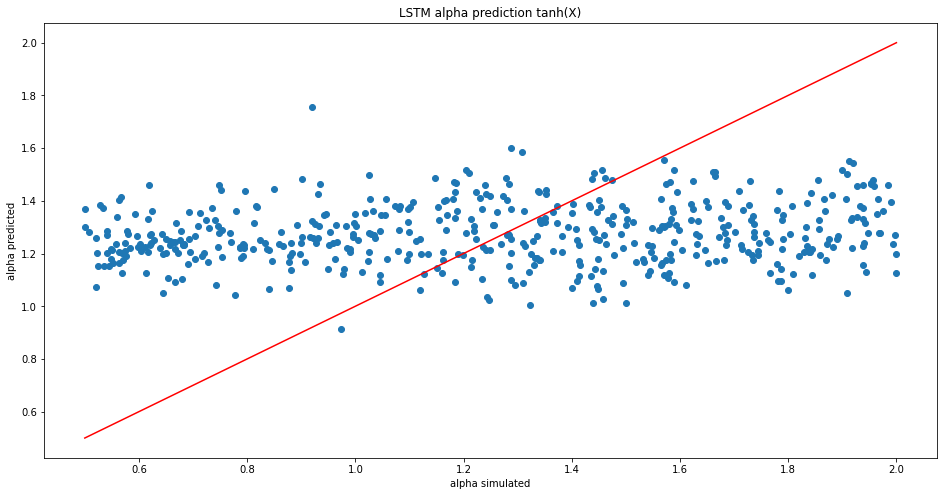

In [32]:
plt.figure(figsize=(16,8))
plt.plot([0.5,2], [0.5,2], 'red')
plt.scatter(simulated, predicted)
plt.xlabel('alpha simulated')
plt.ylabel('alpha predicted')
plt.title('LSTM alpha prediction tanh(X)')
plt.show()

In [33]:
simulated = []
predicted = []

append_index = 0
start = 10000

for i in tqdm(range(start, start + 500, 1)):
    test_input = one_sample_reshape[i]
    test_input_1 = test_input.reshape(1, 1, 999)
    test_output = model.predict(test_input_1, verbose=0)
    # if np.linalg.norm(params_reshape[i][0][0]-test_output[0][0]) <= 1.50:
        # append_index = append_index + 1
        # print(f'appended: {append_index}')
    predicted.append(test_output[0][0])
    simulated.append(params_reshape[i][0][0])
    # else:
    #     None
    
    print(test_output, params_reshape[i])

  1%|          | 3/500 [00:00<03:39,  2.27it/s][[1.27097791]] [[1.53715728]]
[[1.56216564]] [[1.22662438]]
[[1.26401853]] [[0.57036715]]
  1%|          | 5/500 [00:00<02:45,  3.00it/s][[1.48655395]] [[1.30849344]]
[[1.36165984]] [[1.76638857]]
[[1.35685688]] [[1.28168786]]
  2%|▏         | 9/500 [00:01<01:35,  5.17it/s][[1.30397727]] [[1.20971797]]
[[1.26131342]] [[1.17853862]]
[[1.31011446]] [[1.01188175]]
  2%|▏         | 11/500 [00:01<01:17,  6.34it/s][[1.25184305]] [[0.96971706]]
[[1.3021302]] [[1.1995555]]
[[1.25833376]] [[1.87802459]]
  3%|▎         | 13/500 [00:01<01:05,  7.46it/s][[1.41923166]] [[0.71779629]]
[[1.28402558]] [[1.12496277]]
[[1.27460688]] [[1.12231159]]
  3%|▎         | 17/500 [00:01<00:53,  9.06it/s][[1.20212109]] [[1.97727565]]
[[1.34585271]] [[1.89463135]]
  4%|▍         | 19/500 [00:02<00:51,  9.33it/s][[1.38609397]] [[0.64488589]]
[[1.32191484]] [[0.75662442]]
  5%|▍         | 23/500 [00:02<00:41, 11.51it/s][[0.54980206]]
[[1.36805253]] [[1.82618832]]
[[1.39

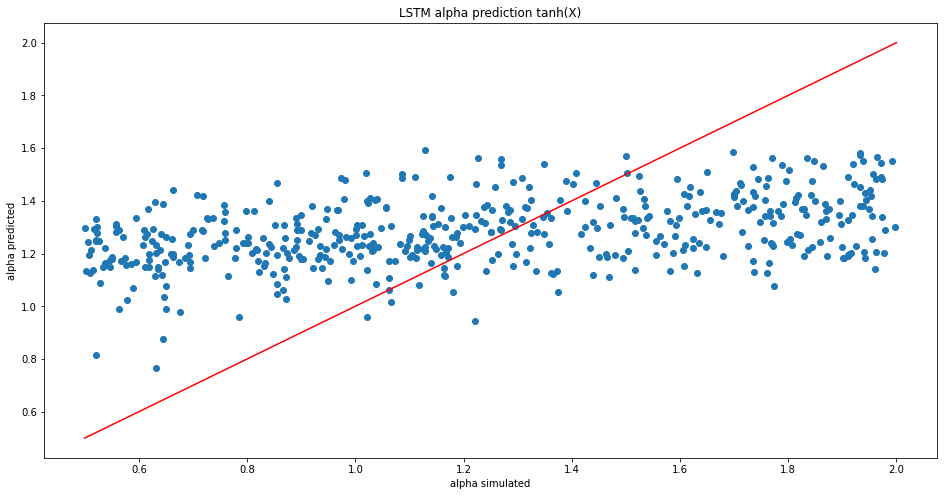

In [34]:
plt.figure(figsize=(16,8))
plt.plot([0.5,2], [0.5,2], 'red')
plt.scatter(simulated, predicted)
plt.xlabel('alpha simulated')
plt.ylabel('alpha predicted')
plt.title('LSTM alpha prediction tanh(X)')
plt.show()

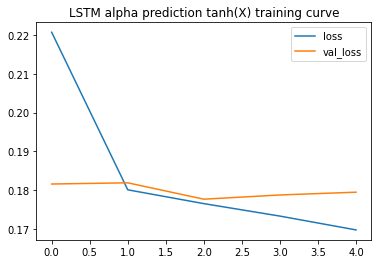

In [35]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('LSTM alpha prediction tanh(X) training curve')
plt.legend(['loss', 'val_loss'])
plt.show()